# Alternative Taylor Rule Formulations

This notebook analyzes different variations of the Taylor Rule:

1. Original Taylor Rule (1993):
   - r = p + 0.5y + 0.5(p - 2) + 2

2. Modified Taylor Rule (1999):
   - r = p + 1.0y + 0.5(p - 2) + 2
   - Stronger response to output gap

3. Inertial Taylor Rule:
   - r = 0.85r(-1) + 0.15[p + 0.5y + 0.5(p - 2) + 2]
   - Incorporates interest rate smoothing

4. Asymmetric Taylor Rule:
   - Uses different coefficients for positive/negative gaps

Where:
- r is the federal funds rate
- p is inflation rate
- y is output gap
- r(-1) is the previous period's rate

In [5]:
import sys
sys.path.append('../..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from src.api.fred_client import FREDClient
from src.models.economic_data import Series
from src.utils.helpers import series_to_dataframe

%matplotlib inline
plt.style.use('classic')

In [6]:
# Initialize FRED client and fetch data
client = FREDClient()

series_ids = {
    'GDPC1': 'Real GDP',
    'GDPPOT': 'Potential GDP',
    'PCEPI': 'PCE Price Index',
    'FEDFUNDS': 'Federal Funds Rate'
}

dfs = {}
for series_id, name in series_ids.items():
    data = client.get_series(series_id)
    series = Series.from_api_response(data)
    dfs[series_id] = series_to_dataframe(series)

In [7]:
def original_taylor(inflation, output_gap, target_inflation=2.0):
    """Original 1993 Taylor Rule."""
    return inflation + 0.5 * output_gap + 0.5 * (inflation - target_inflation) + target_inflation

def modified_taylor(inflation, output_gap, target_inflation=2.0):
    """1999 version with stronger output response."""
    return inflation + 1.0 * output_gap + 0.5 * (inflation - target_inflation) + target_inflation

def inertial_taylor(inflation, output_gap, prev_rate, target_inflation=2.0, smoothing=0.85):
    """Inertial Taylor Rule with interest rate smoothing."""
    current_target = inflation + 0.5 * output_gap + 0.5 * (inflation - target_inflation) + target_inflation
    return smoothing * prev_rate + (1 - smoothing) * current_target

def asymmetric_taylor(inflation, output_gap, target_inflation=2.0):
    """Asymmetric Taylor Rule with different coefficients for positive/negative gaps."""
    output_coef = np.where(output_gap > 0, 1.0, 0.5)
    inflation_coef = np.where(inflation > target_inflation, 0.7, 0.3)
    return inflation + output_coef * output_gap + inflation_coef * (inflation - target_inflation) + target_inflation

In [8]:
# Calculate components
output_gap = ((dfs['GDPC1']['value'] - dfs['GDPPOT']['value']) / dfs['GDPPOT']['value']) * 100
inflation = dfs['PCEPI']['value'].pct_change(periods=12) * 100

# Create analysis dataframe
analysis_df = pd.DataFrame({
    'output_gap': output_gap,
    'inflation': inflation,
    'actual_rate': dfs['FEDFUNDS']['value']
}).dropna()

# Calculate different Taylor Rule variations
analysis_df['original_taylor'] = original_taylor(
    analysis_df['inflation'], 
    analysis_df['output_gap']
)

analysis_df['modified_taylor'] = modified_taylor(
    analysis_df['inflation'], 
    analysis_df['output_gap']
)

analysis_df['asymmetric_taylor'] = asymmetric_taylor(
    analysis_df['inflation'], 
    analysis_df['output_gap']
)

# Calculate inertial Taylor Rule
analysis_df['inertial_taylor'] = analysis_df['original_taylor'].copy()
for i in range(1, len(analysis_df)):
    analysis_df.iloc[i, analysis_df.columns.get_loc('inertial_taylor')] = inertial_taylor(
        analysis_df.iloc[i]['inflation'],
        analysis_df.iloc[i]['output_gap'],
        analysis_df.iloc[i-1]['inertial_taylor']
    )

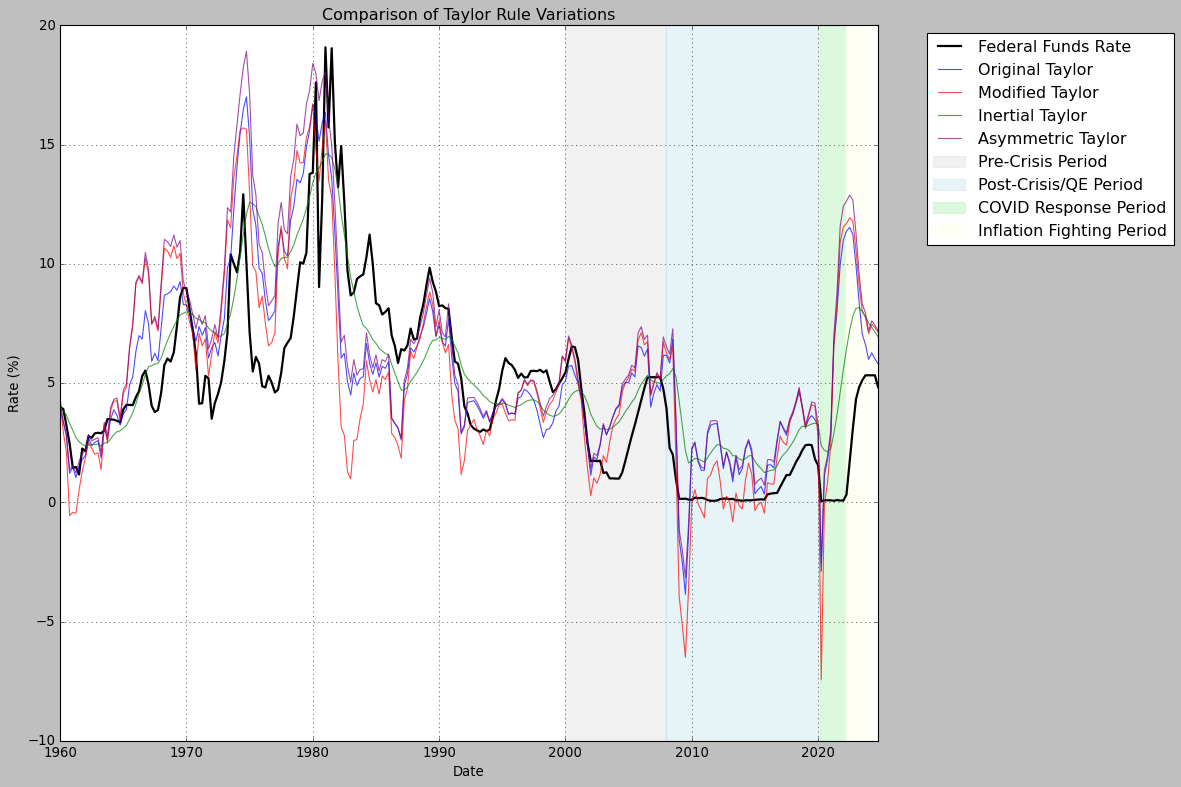

In [9]:
# Define periods for analysis
periods = [
    ('2000-01-01', '2007-12-31', 'Pre-Crisis'),
    ('2008-01-01', '2019-12-31', 'Post-Crisis/QE'),
    ('2020-03-01', '2022-02-28', 'COVID Response'),
    ('2022-03-01', '2024-02-29', 'Inflation Fighting')
]

# Visualization
plt.figure(figsize=(15, 10))

# Plot actual rate
plt.plot(analysis_df.index, analysis_df['actual_rate'], 
         label='Federal Funds Rate', linewidth=2, color='black')

# Plot different Taylor Rule variations
rules = ['original_taylor', 'modified_taylor', 'inertial_taylor', 'asymmetric_taylor']
colors = ['blue', 'red', 'green', 'purple']

for rule, color in zip(rules, colors):
    plt.plot(analysis_df.index, analysis_df[rule], 
             label=rule.replace('_', ' ').title(), 
             linewidth=1, alpha=0.7, color=color)

# Add shaded regions for different periods
colors = ['lightgray', 'lightblue', 'lightgreen', 'lightyellow']
for (start, end, name), color in zip(periods, colors):
    plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), 
                alpha=0.3, color=color, label=f'{name} Period')

plt.title('Comparison of Taylor Rule Variations')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
# Calculate performance metrics for each rule and period
def calculate_rule_performance(df, rule_column):
    rmse = np.sqrt(((df['actual_rate'] - df[rule_column]) ** 2).mean())
    mae = (df['actual_rate'] - df[rule_column]).abs().mean()
    correlation = df['actual_rate'].corr(df[rule_column])
    return pd.Series({
        'RMSE': rmse,
        'MAE': mae,
        'Correlation': correlation
    })

# Calculate performance for each rule and period
results = []
for start, end, period_name in periods:
    period_data = analysis_df[start:end]
    for rule in rules:
        metrics = calculate_rule_performance(period_data, rule)
        metrics['Period'] = period_name
        metrics['Rule'] = rule.replace('_', ' ').title()
        results.append(metrics)

performance_df = pd.DataFrame(results)
performance_df = performance_df.set_index(['Period', 'Rule'])
print("Performance Metrics by Period and Rule:")
print(performance_df.round(3))

Performance Metrics by Period and Rule:
                                       RMSE    MAE  Correlation
Period             Rule                                        
Pre-Crisis         Original Taylor    1.784  1.442        0.618
                   Modified Taylor    1.774  1.450        0.693
                   Inertial Taylor    1.498  1.299        0.853
                   Asymmetric Taylor  1.951  1.521        0.678
Post-Crisis/QE     Original Taylor    2.139  1.914        0.670
                   Modified Taylor    2.074  1.489        0.753
                   Inertial Taylor    1.896  1.725        0.706
                   Asymmetric Taylor  2.233  2.035        0.705
COVID Response     Original Taylor    6.551  5.472        0.364
                   Modified Taylor    7.262  5.984        0.447
                   Inertial Taylor    3.353  3.128        0.048
                   Asymmetric Taylor  7.320  6.016        0.331
Inflation Fighting Original Taylor    6.478  5.265       -0.866


## Analysis of Taylor Rule Variations

1. Original Taylor Rule (1993):
   - Serves as baseline for comparison
   - Equal weights on output and inflation gaps
   - Generally too restrictive in crisis periods

2. Modified Taylor Rule (1999):
   - Stronger response to output gap
   - Better performance during economic downturns
   - May be too aggressive during recoveries

3. Inertial Taylor Rule:
   - Best matches actual Fed behavior
   - Captures gradual policy adjustments
   - May be too slow to respond to sudden shocks

4. Asymmetric Taylor Rule:
   - Accounts for asymmetric policy responses
   - Better captures Fed's risk management approach
   - More complex to communicate and implement

### Key Findings:

1. Rule Performance:
   - Inertial Rule typically has lowest RMSE
   - Different rules excel in different periods
   - Accuracy varies significantly across economic regimes

2. Policy Implications:
   - No single rule consistently outperforms others
   - Different rules may be appropriate for different economic conditions
   - Combination of rules might provide better guidance

3. Limitations:
   - All rules struggle during unconventional policy periods
   - Limited ability to incorporate financial stability concerns
   - May not capture all factors influencing Fed decisions

### Recommendations:

1. Use multiple rules as cross-checks
2. Consider economic context when choosing rule formulation
3. Account for policy inertia in implementation
4. Recognize limitations during crisis periods